In [10]:
### Imports

from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import seaborn as sns
import scipy

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras import metrics # https://keras.io/metrics/ - ver a parte de custom metrics
from keras.callbacks import History 
from keras.utils.vis_utils import plot_model

import tensorflow as tf

### Funções minhas

# Adicionando ruído às imagens
def add_noise(sigma, bw_img):
    """Adiciona ruído a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(0, sigma, sh)
    newgray = bw_img + noise
    #np.clip(newgray, 0, 1) # quando faço isso ela deixa de ser normal!!!
    # vou parar de clipar.
    return newgray

def plot_original_reconstructed(pred, numero):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(faces[numero].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(newfaces[numero].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(pred[numero].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

def plot_compare(idx, original, noisy, predicted):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(original[idx].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(noisy[idx].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(predicted[idx].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

## Funcao custo customizada: SSIM

def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [11]:
### Base de dados

db = fetch_lfw_people()

faces = db['data']
total_imagens = len(faces)
faces_matrix = np.empty((total_imagens, 60, 44))

for i in range(total_imagens):
    faces_matrix[i] = faces[i].reshape(62, 47)[1:61, 1:45]

# Normalizando imagens
faces_matrix = faces_matrix/np.amax(faces_matrix)

# Adicionando ruído de sd = 0.05
del faces
faces = faces_matrix
noisyfaces = add_noise(0.05, faces)


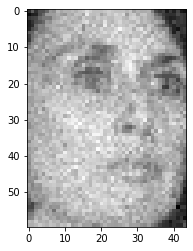

In [12]:
plt.imshow(noisyfaces[5], cmap = 'gray')

In [13]:
## Train and test split

treino, teste, newtreino, newteste = train_test_split(faces_matrix, noisyfaces, test_size = 0.1, random_state = 1)
# refazer com test_size = 0.1

newtreino = newtreino.reshape(-1, 60, 44, 1)
treino = treino.reshape(-1, 60, 44, 1)

newteste = newteste.reshape(-1, 60, 44, 1)
teste = teste.reshape(-1, 60, 44, 1)

In [58]:
### Escolhendo métricas que serão monitoradas

# Funções custo e métricas podem ser utilizadas como métricas
metricas = [ ###### LOSSES:
            'mean_squared_error', 'mean_absolute_error',
            #'cosine_proximity',
            #'mean_absolute_percentage_error', 'mean_squared_logarithmic_error',
            #'hinge', 'squared_hinge', 'logcosh', 
            'binary_crossentropy', 
            #'huber_loss', 
            #'kullback_leibler_divergence',
            #'poisson',
             ###### METRICS:
            'accuracy' 
            #, 'binary_accuracy'
            ] # as outras metrics são categóricas.



In [60]:
autoencoders = [None]
historias = [None]

cont = 0

def make_autoencoder():
  # encoding
  inputs = Input(shape=(60, 44, 1)) 
  x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
  x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
  x = Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
  encoded = MaxPooling2D(padding = 'same')(x)

  # decoding
  x = UpSampling2D(size = (2, 2))(x)
  decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 

  # autoencoder compilation
  autoencoder = Model(inputs, decoded)
  autoencoder.compile(optimizer = 'adam', loss = "mse", metrics = metricas)
  return autoencoder
autoencoders[cont] = make_autoencoder()
historias[cont] = History()

autoencoders[cont].fit(newtreino, treino, epochs=200, batch_size=128, callbacks=[historias[cont]], validation_split = 0.1)

Train on 10718 samples, validate on 1191 samples
Epoch 1/200
10718/10718 [==============================] - 17s 2ms/step - loss: 0.0267 - mean_squared_error: 0.0267 - mean_absolute_error: 0.1284 - binary_crossentropy: 0.6812 - accuracy: 4.5555e-05 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0676 - val_binary_crossentropy: 0.6448 - val_accuracy: 4.9615e-05
Epoch 2/200
10718/10718 [==============================] - 16s 2ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0453 - binary_crossentropy: 0.6337 - accuracy: 5.7889e-05 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0387 - val_binary_crossentropy: 0.6311 - val_accuracy: 4.9615e-05
Epoch 3/200
10718/10718 [==============================] - 17s 2ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0361 - binary_crossentropy: 0.6300 - accuracy: 5.7889e-05 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_me

Epoch 45/200
10718/10718 [==============================] - 23s 2ms/step - loss: 7.9832e-04 - mean_squared_error: 7.9832e-04 - mean_absolute_error: 0.0216 - binary_crossentropy: 0.6249 - accuracy: 5.7889e-05 - val_loss: 7.9121e-04 - val_mean_squared_error: 7.9121e-04 - val_mean_absolute_error: 0.0215 - val_binary_crossentropy: 0.6251 - val_accuracy: 4.9615e-05
Epoch 46/200
10718/10718 [==============================] - 23s 2ms/step - loss: 8.0009e-04 - mean_squared_error: 8.0009e-04 - mean_absolute_error: 0.0216 - binary_crossentropy: 0.6249 - accuracy: 5.7889e-05 - val_loss: 7.9955e-04 - val_mean_squared_error: 7.9955e-04 - val_mean_absolute_error: 0.0216 - val_binary_crossentropy: 0.6251 - val_accuracy: 4.9615e-05
Epoch 47/200
10718/10718 [==============================] - 24s 2ms/step - loss: 7.9270e-04 - mean_squared_error: 7.9270e-04 - mean_absolute_error: 0.0215 - binary_crossentropy: 0.6249 - accuracy: 5.7889e-05 - val_loss: 7.8798e-04 - val_mean_squared_error: 7.8798e-04 - val_

Epoch 68/200
10718/10718 [==============================] - 24s 2ms/step - loss: 7.5831e-04 - mean_squared_error: 7.5831e-04 - mean_absolute_error: 0.0211 - binary_crossentropy: 0.6248 - accuracy: 5.7889e-05 - val_loss: 7.5156e-04 - val_mean_squared_error: 7.5156e-04 - val_mean_absolute_error: 0.0210 - val_binary_crossentropy: 0.6250 - val_accuracy: 4.9615e-05
Epoch 69/200
10718/10718 [==============================] - 24s 2ms/step - loss: 7.5542e-04 - mean_squared_error: 7.5542e-04 - mean_absolute_error: 0.0210 - binary_crossentropy: 0.6248 - accuracy: 5.7889e-05 - val_loss: 7.5093e-04 - val_mean_squared_error: 7.5093e-04 - val_mean_absolute_error: 0.0210 - val_binary_crossentropy: 0.6250 - val_accuracy: 4.9615e-05
Epoch 70/200
10718/10718 [==============================] - 24s 2ms/step - loss: 7.5775e-04 - mean_squared_error: 7.5775e-04 - mean_absolute_error: 0.0211 - binary_crossentropy: 0.6248 - accuracy: 5.7889e-05 - val_loss: 7.4998e-04 - val_mean_squared_error: 7.4998e-04 - val_

Epoch 91/200
10718/10718 [==============================] - 24s 2ms/step - loss: 7.3784e-04 - mean_squared_error: 7.3784e-04 - mean_absolute_error: 0.0208 - binary_crossentropy: 0.6248 - accuracy: 5.7889e-05 - val_loss: 7.3212e-04 - val_mean_squared_error: 7.3212e-04 - val_mean_absolute_error: 0.0208 - val_binary_crossentropy: 0.6249 - val_accuracy: 4.9615e-05
Epoch 92/200
10718/10718 [==============================] - 24s 2ms/step - loss: 7.3881e-04 - mean_squared_error: 7.3881e-04 - mean_absolute_error: 0.0208 - binary_crossentropy: 0.6248 - accuracy: 5.7889e-05 - val_loss: 7.4475e-04 - val_mean_squared_error: 7.4475e-04 - val_mean_absolute_error: 0.0209 - val_binary_crossentropy: 0.6250 - val_accuracy: 4.9615e-05
Epoch 93/200
10718/10718 [==============================] - 24s 2ms/step - loss: 7.4049e-04 - mean_squared_error: 7.4049e-04 - mean_absolute_error: 0.0209 - binary_crossentropy: 0.6248 - accuracy: 5.7889e-05 - val_loss: 7.3866e-04 - val_mean_squared_error: 7.3866e-04 - val_

10718/10718 [==============================] - 19s 2ms/step - loss: 7.2503e-04 - mean_squared_error: 7.2503e-04 - mean_absolute_error: 0.0207 - binary_crossentropy: 0.6247 - accuracy: 5.7889e-05 - val_loss: 7.2860e-04 - val_mean_squared_error: 7.2860e-04 - val_mean_absolute_error: 0.0208 - val_binary_crossentropy: 0.6249 - val_accuracy: 4.9615e-05
Epoch 136/200
10718/10718 [==============================] - 20s 2ms/step - loss: 7.2069e-04 - mean_squared_error: 7.2069e-04 - mean_absolute_error: 0.0206 - binary_crossentropy: 0.6247 - accuracy: 5.7889e-05 - val_loss: 7.1452e-04 - val_mean_squared_error: 7.1452e-04 - val_mean_absolute_error: 0.0205 - val_binary_crossentropy: 0.6249 - val_accuracy: 4.9615e-05
Epoch 137/200
10718/10718 [==============================] - 21s 2ms/step - loss: 7.2232e-04 - mean_squared_error: 7.2232e-04 - mean_absolute_error: 0.0206 - binary_crossentropy: 0.6247 - accuracy: 5.7889e-05 - val_loss: 7.1510e-04 - val_mean_squared_error: 7.1510e-04 - val_mean_absolu

10718/10718 [==============================] - 19s 2ms/step - loss: 7.1865e-04 - mean_squared_error: 7.1865e-04 - mean_absolute_error: 0.0206 - binary_crossentropy: 0.6247 - accuracy: 5.7889e-05 - val_loss: 7.0411e-04 - val_mean_squared_error: 7.0411e-04 - val_mean_absolute_error: 0.0204 - val_binary_crossentropy: 0.6249 - val_accuracy: 4.9615e-05
Epoch 180/200
10718/10718 [==============================] - 19s 2ms/step - loss: 7.0887e-04 - mean_squared_error: 7.0887e-04 - mean_absolute_error: 0.0205 - binary_crossentropy: 0.6247 - accuracy: 5.7889e-05 - val_loss: 7.0444e-04 - val_mean_squared_error: 7.0444e-04 - val_mean_absolute_error: 0.0204 - val_binary_crossentropy: 0.6249 - val_accuracy: 4.9615e-05
Epoch 181/200
10718/10718 [==============================] - 19s 2ms/step - loss: 7.0838e-04 - mean_squared_error: 7.0838e-04 - mean_absolute_error: 0.0204 - binary_crossentropy: 0.6247 - accuracy: 5.7889e-05 - val_loss: 7.0356e-04 - val_mean_squared_error: 7.0356e-04 - val_mean_absolu

In [62]:
# after running, save keras model with
autoencoders[0].save('200iter_MSE_val10')

In [63]:
# and save history with
import pickle
pickle.dump(historias[0], open( "save_historias_200iter_mse_val10", "wb" ) )

In [64]:
predicoes_treino = autoencoders[cont].predict(newtreino) # in sample
predicoes_teste = autoencoders[cont].predict(newteste) # out of sample

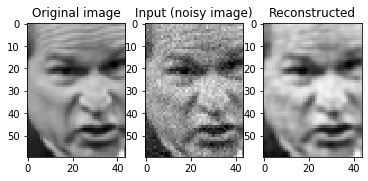

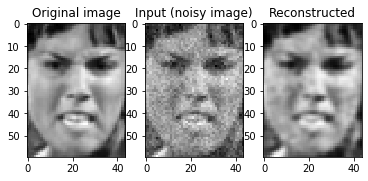

In [66]:
plot_compare(25, teste, newteste, predicoes_teste) # out of sample prediction

plot_compare(15, treino, newtreino, predicoes_treino) # in sample prediction - should be better

In [ ]:
cont = 0
sns.lineplot(range(len(historias[cont].history['loss'])), historias[cont].history['loss']).set_title('loss')

sns.lineplot(range(len(historias[cont].history['val_loss'])), historias[cont].history['val_loss']).set_title('validation loss')

sns.lineplot(range(len(historias[cont].history['mean_squared_error'])), historias[cont].history['mean_squared_error']).set_title('mean_squared_error')

sns.lineplot(range(len(historias[cont].history['val_mean_squared_error'])), historias[cont].history['val_mean_squared_error']).set_title('val_mean_squared_error')

sns.lineplot(range(len(historias[cont].history['accuracy'])), historias[cont].history['accuracy']).set_title('accuracy')

# Loading objects in another session

## MSE cost function, 200 iter

In [1]:
from keras.models import load_model
import pickle

Using TensorFlow backend.


In [2]:
modelo = load_model('200iter_MSE')
historias = pickle.load( open( "save_historias_200iter_mse", "rb" ) )

Metrics inside the history object

'loss'
'mean_squared_error' (which is the same as loss in this scenario)
'mean_absolute_error'
'binary_crossentropy'
'accuracy' 

'val_loss'
'val_mean_squared_error' (which is the same as loss in this scenario)
'val_mean_absolute_error'
'val_binary_crossentropy'
'val_accuracy' 

In [3]:
import seaborn as sns

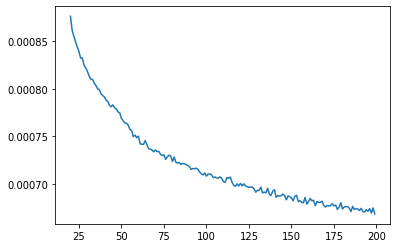

In [4]:
start = 20
finish = 200

y = historias.history['loss'][start:finish]
x = range(start, finish)
sns.lineplot(x, y)

Comparing 2 different training stories

In [78]:
historias8020 = pickle.load( open( "save_historias_200iter_mse", "rb" ) )
historias9010 = pickle.load( open( "save_historias_200iter_mse_val10", "rb" ) )

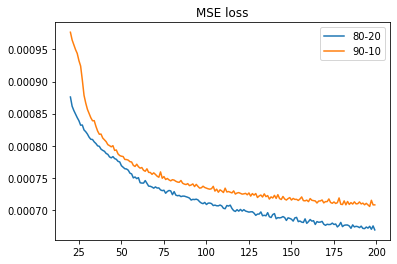

In [97]:
start = 20
finish = 200

f, ax = plt.subplots(1, 1)
y1 = historias8020.history['loss'][start:finish]
y2 = historias9010.history['loss'][start:finish]
x = range(start, finish)
sns.lineplot(x, y1, legend="full").set_title('MSE loss')
sns.lineplot(x, y2, legend="full")

ax.legend(("80-20", "90-10"))

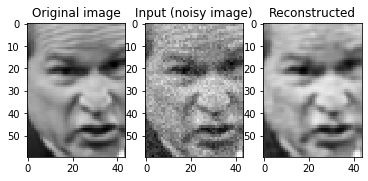

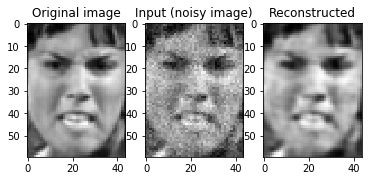

In [8]:
predicoes_treino = modelo.predict(newtreino) # in sample
predicoes_teste = modelo.predict(newteste) # out of sample
plot_compare(25, teste, newteste, predicoes_teste) # out of sample prediction

plot_compare(15, treino, newtreino, predicoes_treino) # in sample prediction - should be better

Calculating MSE, in-sample and out-of-sample

In [7]:
predicoes_treino = modelo.predict(newtreino) # in sample
predicoes_teste = modelo.predict(newteste) # out of sample

In [23]:
len(predicoes_treino)

11909

In [21]:
len(predicoes_teste)

1324

In [27]:
len(newteste)

1324

In [14]:
mse_list_treino = np.zeros(len(predicoes_treino))
for i in range(len(predicoes_treino)):
    mse_list_treino[i] = np.mean((predicoes_treino[i] - newtreino[i])**2)

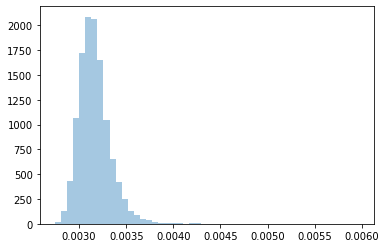

In [42]:
sns.distplot(mse_list_treino,  norm_hist=False, kde=False)

In [17]:
np.mean(mse_list_treino)

0.0031651248959876236

In [18]:
np.mean((predicoes_treino - newtreino)**2)

0.003165124895987623

In [25]:
del(mse_list_teste)
mse_list_teste = np.zeros(len(predicoes_teste))
for i in range(len(predicoes_teste)):
    mse_list_teste[i] = np.mean((predicoes_teste[i] - newteste[i])**2)
len(mse_list_teste)

1324

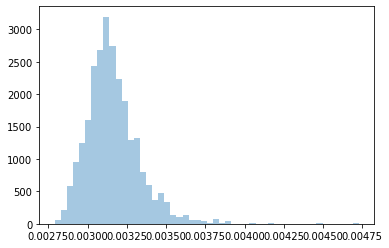

In [37]:
sns.distplot(mse_list_teste, norm_hist=False, kde=False)

In [31]:
np.mean(mse_list_teste)

0.0031629761988524224

In [32]:
np.mean((predicoes_teste - newteste)**2)

0.003162976198852421

(0.0025, 0.004)

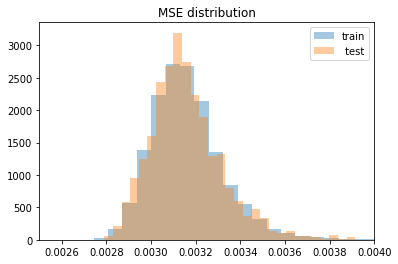

In [69]:
sns.distplot(mse_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(mse_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("MSE distribution")

plt.xlim(0.0025, 0.0040)

Calculating SSIM, in-sample and out-of-sample

In [46]:
from skimage import measure

In [47]:
newtreino[0].shape

(60, 44, 1)

In [48]:
predicoes_treino[2].shape

(60, 44, 1)

In [49]:
predicoes_treino[2,:,:,0].shape

(60, 44)

In [50]:
ssim_list_treino = np.zeros(len(predicoes_treino))
for i in range(len(predicoes_treino)):
    ssim_list_treino[i] = measure.compare_ssim(newtreino[i,:,:,0], predicoes_treino[i,:,:,0])

C:\Users\User\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


In [51]:
ssim_list_teste = np.zeros(len(predicoes_teste))
for i in range(len(predicoes_teste)):
    ssim_list_teste[i] = measure.compare_ssim(newteste[i,:,:,0], predicoes_teste[i,:,:,0])

In [52]:
ssim_list_treino

array([0.76815895, 0.79662001, 0.83726307, ..., 0.78794156, 0.77471335,
       0.82942797])

Text(0.5, 1.0, 'Distribution for SSIM - train/test')

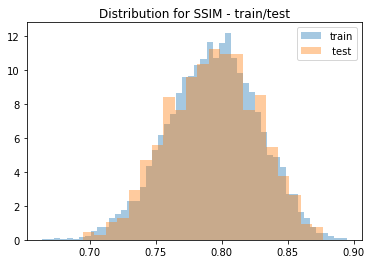

In [59]:
sns.distplot(ssim_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(ssim_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("Distribution for SSIM - train/test")

In [ ]:
import plotly.express as px

fig = px.line(x, x, y) # primeiro argumento tem que ser um df, isso é gambiarra
fig.show()

## Trying to load the SSIM network (200 iter) - failed!!

In [ ]:
def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [ ]:
modelo = load_model('200iter_SSIM', compile=False)

In [ ]:
modelo.compile(optimizer = 'adam', loss = ssim_loss)

In [ ]:
historias = pickle.load( open( "save_historias_200iter_ssim", "rb" ))

It is unsafe to pickle a Keras model. Rather than doing this, consider using model.save(path, format='tf'),
which will use the SavedModel format and which will also include the custom objects. - https://github.com/tensorflow/tensorflow/issues/32818